In [1]:
import pandas as pd
import ast
from scipy.special import softmax
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

model_names = ["LLaMA3.2-1B", "LLaMA3.2-3B", "Qwen2.5-1.5B", "Qwen2.5-3B"]

info_df = pd.read_csv("../Data Files/results.csv")
outputs_df = pd.read_csv("../Data Files/results-output.csv")

In [2]:
results_df = pd.concat([info_df, outputs_df], axis=1)
results_df.to_csv('../Data Files/complete_results.csv', index=None)

In [3]:
for name in model_names:
    results_df[f'{name}_context_weights'] = results_df[f'{name}_context_weights'].apply(ast.literal_eval)
    results_df[f'{name}_question_weights'] = results_df[f'{name}_question_weights'].apply(ast.literal_eval)
    results_df[f'{name}_context_ave'] = results_df[f'{name}_context_ave'].apply(ast.literal_eval)
    results_df[f'{name}_question_ave'] = results_df[f'{name}_question_ave'].apply(ast.literal_eval)
    results_df[f'{name}_total_ave'] = results_df[f'{name}_total_ave'].apply(ast.literal_eval)

In [4]:
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.special import softmax

def softmax_transform(data):
    return np.array(softmax(data), dtype='float32').reshape(1, -1)

def get_similarity(llm_attn, human_attn):
    normalized_llm = np.array(llm_attn, dtype='float32').reshape(1, -1)
    normalized_human = softmax_transform(human_attn)
    return cosine_similarity(normalized_llm, normalized_human)[0][0]

In [5]:
for name in model_names:
    results_df[f'{name}_context_similarity'] = results_df.apply(lambda row: get_similarity(row[f'{name}_context_ave'], row[f'{name}_context_weights']), axis=1)
    results_df[f'{name}_question_similarity'] = results_df.apply(lambda row: get_similarity(row[f'{name}_question_ave'], row[f'{name}_question_weights']), axis=1)
    results_df[f'{name}_context_length'] = results_df['context'].apply(lambda x: len(x))
    results_df[f'{name}_question_length'] = results_df['question'].apply(lambda x: len(x))

In [6]:
context_corrs = [0, 0, 0, 0]
question_corrs = [0, 0, 0, 0]

for i in range(len(model_names)):
    name = model_names[i]
    context_corrs[i] = results_df[f'{name}_context_similarity'].corr(results_df[f'{name}_context_length'])
    question_corrs[i] = results_df[f'{name}_question_similarity'].corr(results_df[f'{name}_question_length'])

In [7]:
# Get similarity average for all models
similarities = [0, 0, 0, 0]
for i in range(len(model_names)):
    name = model_names[i]
    similarities[i] = (results_df[f'{name}_context_similarity'].mean(), results_df[f'{name}_question_similarity'].mean())
    print(similarities[i])

(np.float32(0.8420906), np.float32(0.8828699))
(np.float32(0.7998411), np.float32(0.88757026))
(np.float32(0.76227444), np.float32(0.87302494))
(np.float32(0.71253437), np.float32(0.87978154))


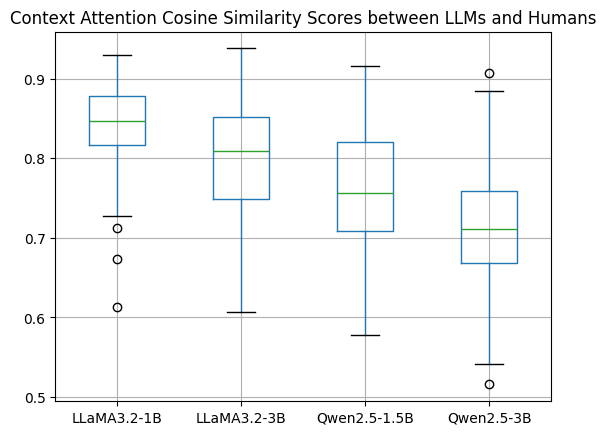

In [8]:
cols = []
labels = []
for name in model_names:
    cols.append(f'{name}_context_similarity')
    labels.append(name)

plot = results_df.boxplot(column=cols)
plot.set_xticklabels(labels)
plt.title('Context Attention Cosine Similarity Scores between LLMs and Humans')
plt.show()

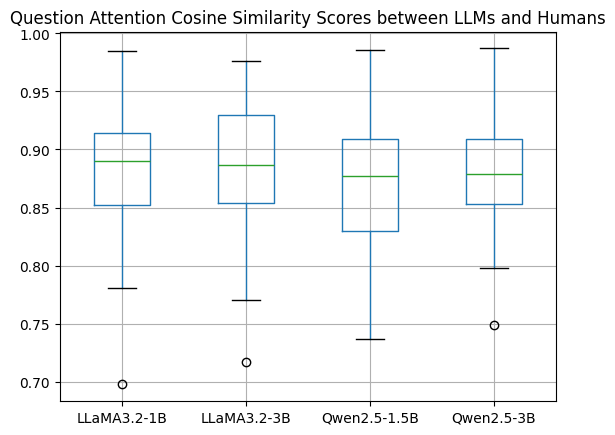

In [9]:
cols = []
labels = []
for name in model_names:
    cols.append(f'{name}_question_similarity')
    labels.append(name)

plot = results_df.boxplot(column=cols)
plot.set_xticklabels(labels)
plt.title('Question Attention Cosine Similarity Scores between LLMs and Humans')
plt.show()

In [10]:
# Get all grouped types
types = [0, 0, 0, 0]
for i in range(4):
    types[i] = results_df[results_df['type'] == i]

In [11]:
# Get average attention and similarity to humans on context and question for all types for each model
type_data = [pd.DataFrame() for _ in range(4)]

for i in range(4):
    for name in model_names:
        type_data[i][f'{name}_context_attention_{i}'] = types[i].apply(lambda row: sum(row[f'{name}_context_ave']) / sum(row[f'{name}_total_ave']), axis=1)
        type_data[i][f'{name}_question_attention_{i}'] = types[i].apply(lambda row: sum(row[f'{name}_question_ave']) / sum(row[f'{name}_total_ave']), axis=1)
        type_data[i][f'{name}_context_similarity_{i}'] = types[i][f'{name}_context_similarity']
        type_data[i][f'{name}_question_similarity_{i}'] = types[i][f'{name}_question_similarity']
        

In [12]:
type_summary = pd.DataFrame(columns=['type', 'model', 'avg_context_attn', 'avg_question_attn', 'avg_context_similarity', 'avg_question_similarity'])

for i in range(4):
    for name in model_names:
        type_summary.loc[len(type_summary)] = [i, name, type_data[i][f'{name}_context_attention_{i}'].mean(), 
                                               type_data[i][f'{name}_question_attention_{i}'].mean(), type_data[i][f'{name}_context_similarity_{i}'].mean(), 
                                               type_data[i][f'{name}_question_similarity_{i}'].mean()]

type_summary.sort_values(by=['model', 'type'], ascending=[True, True])

,type,model,avg_context_attn,avg_question_attn,avg_context_similarity,avg_question_similarity
0,0,LLaMA3.2-1B,0.054910,0.042951,0.811498,0.901077
4,1,LLaMA3.2-1B,0.030465,0.047548,0.860803,0.884060
8,2,LLaMA3.2-1B,0.032769,0.046383,0.836937,0.874830
12,3,LLaMA3.2-1B,0.026317,0.049272,0.859124,0.871512
1,0,LLaMA3.2-3B,0.067296,0.039722,0.759143,0.901499
5,1,LLaMA3.2-3B,0.028159,0.041861,0.826823,0.883765
9,2,LLaMA3.2-3B,0.036519,0.046398,0.793652,0.882230
13,3,LLaMA3.2-3B,0.024156,0.049490,0.819746,0.882787
2,0,Qwen2.5-1.5B,0.057188,0.037594,0.766828,0.894368
6,1,Qwen2.5-1.5B,0.041242,0.027524,0.789444,0.882133


In [13]:
model_data = [0, 0, 0, 0]
for x in range(len(model_names)):
    name = model_names[x]
    model_data[x] = pd.concat([type_data[t][[f'{name}_context_attention_{t}', f'{name}_question_attention_{t}', f'{name}_context_similarity_{t}', f'{name}_question_similarity_{t}']].reset_index(drop=True) for t in range(len(type_data))], axis=1)

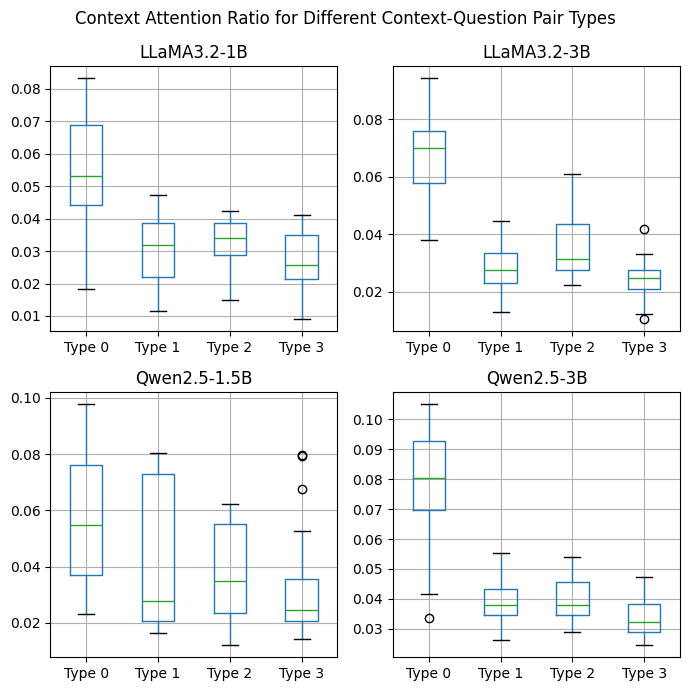

In [14]:
cols = []
labels = []

fig, axes = plt.subplots(2, 2, figsize=(7, 7))

for x in range(len(model_names)):
    name = model_names[x]
    cols.append([])
    labels.append([])
    for i in range(4):
        cols[x].append(f'{name}_context_attention_{i}')
        labels[x].append(f'Type {i}')
    model_data[x].boxplot(column=cols[x], ax=axes[x//2, x%2])
    axes[x//2, x%2].set_title(model_names[x])
    axes[x//2, x%2].set_xticklabels(labels[x])
    
plt.suptitle('Context Attention Ratio for Different Context-Question Pair Types')
plt.tight_layout()
plt.show()

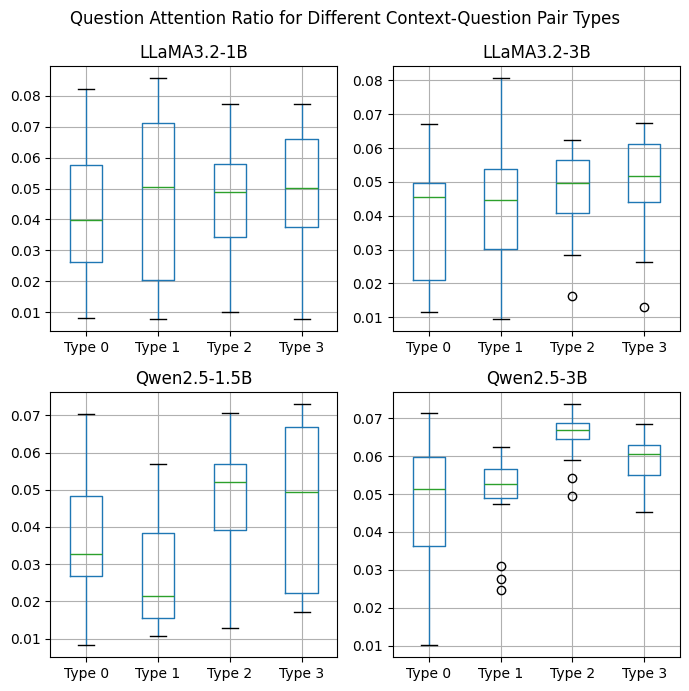

In [15]:
cols = []
labels = []

fig, axes = plt.subplots(2, 2, figsize=(7, 7))

for x in range(len(model_names)):
    name = model_names[x]
    cols.append([])
    labels.append([])
    for i in range(4):
        cols[x].append(f'{name}_question_attention_{i}')
        labels[x].append(f'Type {i}')
    model_data[x].boxplot(column=cols[x], ax=axes[x//2, x%2])
    axes[x//2, x%2].set_title(model_names[x])
    axes[x//2, x%2].set_xticklabels(labels[x])
    
plt.suptitle('Question Attention Ratio for Different Context-Question Pair Types')    
plt.tight_layout()
plt.show()

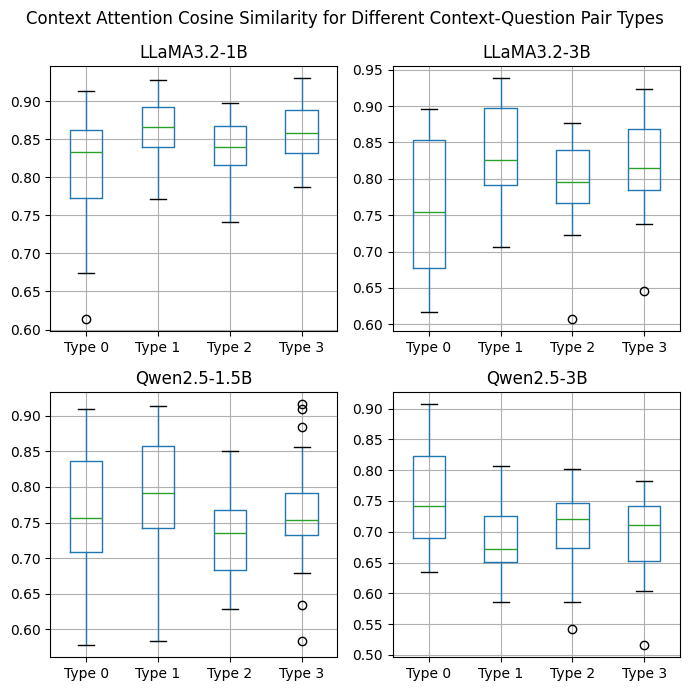

In [16]:
cols = []
labels = []

fig, axes = plt.subplots(2, 2, figsize=(7, 7))

for x in range(len(model_names)):
    name = model_names[x]
    cols.append([])
    labels.append([])
    for i in range(4):
        cols[x].append(f'{name}_context_similarity_{i}')
        labels[x].append(f'Type {i}')
    model_data[x].boxplot(column=cols[x], ax=axes[x//2, x%2])
    axes[x//2, x%2].set_title(model_names[x])
    axes[x//2, x%2].set_xticklabels(labels[x])

plt.suptitle('Context Attention Cosine Similarity for Different Context-Question Pair Types')    
plt.tight_layout()
plt.show()

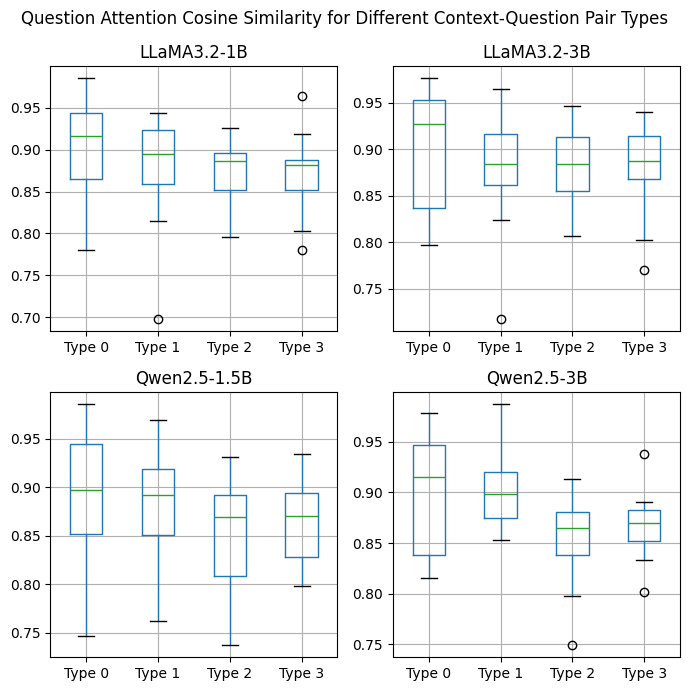

In [17]:
cols = []
labels = []

fig, axes = plt.subplots(2, 2, figsize=(7, 7))

for x in range(len(model_names)):
    name = model_names[x]
    cols.append([])
    labels.append([])
    for i in range(4):
        cols[x].append(f'{name}_question_similarity_{i}')
        labels[x].append(f'Type {i}')
    model_data[x].boxplot(column=cols[x], ax=axes[x//2, x%2])
    axes[x//2, x%2].set_title(model_names[x])
    axes[x//2, x%2].set_xticklabels(labels[x])

plt.suptitle('Question Attention Cosine Similarity for Different Context-Question Pair Types')   
plt.tight_layout()
plt.show()

In [18]:
#Filtering to remove model hallucinations
import pandas as pd
import ast
from scipy.special import softmax

annotated_results_df = pd.read_csv('../Data Files/annotated_complete_results.csv')

In [19]:
name = "Qwen2.5-1.5B"
filtered_df = annotated_results_df[annotated_results_df[f'{name}_hallucinated'] == False]

In [20]:
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.special import softmax

def softmax_transform(data):
    return np.array(softmax(data), dtype='float32').reshape(1, -1)

def get_similarity(llm_attn, human_attn):
    normalized_llm = np.array(llm_attn, dtype='float32').reshape(1, -1)
    normalized_human = softmax_transform(human_attn)
    return cosine_similarity(normalized_llm, normalized_human)[0][0]


In [21]:
for name in model_names:
    filtered_df[f'{name}_context_weights'] = filtered_df[f'{name}_context_weights'].apply(ast.literal_eval)
    filtered_df[f'{name}_question_weights'] = filtered_df[f'{name}_question_weights'].apply(ast.literal_eval)
    filtered_df[f'{name}_context_ave'] = filtered_df[f'{name}_context_ave'].apply(ast.literal_eval)
    filtered_df[f'{name}_question_ave'] = filtered_df[f'{name}_question_ave'].apply(ast.literal_eval)
    filtered_df[f'{name}_total_ave'] = filtered_df[f'{name}_total_ave'].apply(ast.literal_eval)

In [22]:
for name in model_names:
    filtered_df[f'{name}_context_similarity'] = filtered_df.apply(lambda row: get_similarity(row[f'{name}_context_ave'], row[f'{name}_context_weights']), axis=1)
    filtered_df[f'{name}_question_similarity'] = filtered_df.apply(lambda row: get_similarity(row[f'{name}_question_ave'], row[f'{name}_question_weights']), axis=1)

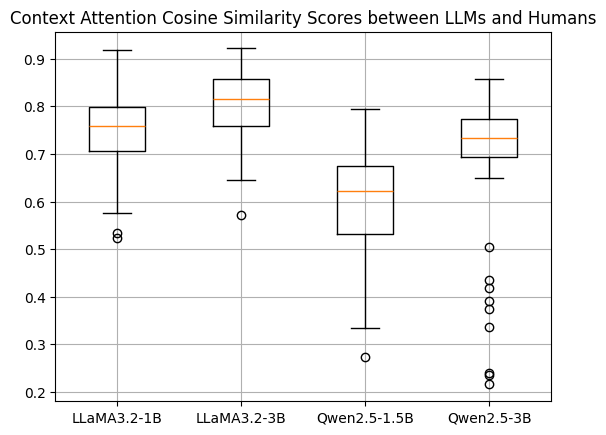

In [23]:
labels = []
for name in model_names:
    labels.append(name)

plt.boxplot([filtered_df[f'{model_names[0]}_context_similarity'], filtered_df[f'{model_names[1]}_context_similarity'],
            filtered_df[f'{model_names[2]}_context_similarity'], filtered_df[f'{model_names[3]}_context_similarity']], labels=labels)
plt.title('Context Attention Cosine Similarity Scores between LLMs and Humans')
plt.grid(True)
plt.show()

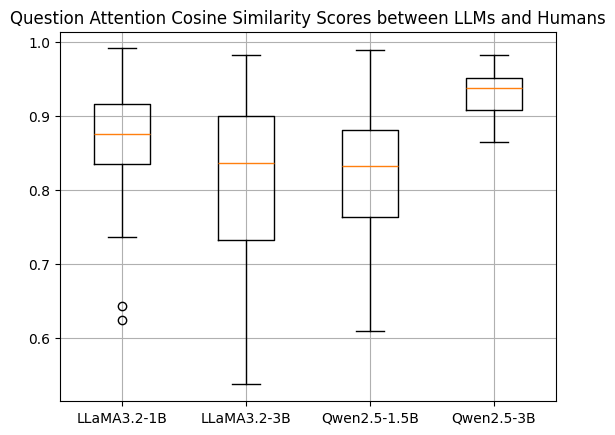

In [24]:
plt.boxplot([filtered_df[f'{model_names[0]}_question_similarity'], filtered_df[f'{model_names[1]}_question_similarity'],
            filtered_df[f'{model_names[2]}_question_similarity'], filtered_df[f'{model_names[3]}_question_similarity']], labels=labels)
plt.title('Question Attention Cosine Similarity Scores between LLMs and Humans')
plt.grid(True)
plt.show()

In [25]:
name = model_names[2]

In [26]:
# Get all grouped types
types = [0, 0, 0, 0]
for i in range(4):
    types[i] = filtered_df[filtered_df['type'] == i]

In [27]:
type_data = [pd.DataFrame() for _ in range(4)]

for i in range(4):
    type_data[i][f'{name}_context_attention_{i}'] = types[i].apply(lambda row: sum(row[f'{name}_context_ave']) / sum(row[f'{name}_total_ave']), axis=1)
    type_data[i][f'{name}_question_attention_{i}'] = types[i].apply(lambda row: sum(row[f'{name}_question_ave']) / sum(row[f'{name}_total_ave']), axis=1)
    type_data[i][f'{name}_context_similarity_{i}'] = types[i][f'{name}_context_similarity']
    type_data[i][f'{name}_question_similarity_{i}'] = types[i][f'{name}_question_similarity']


In [28]:
type_summary = pd.DataFrame(columns=['type', 'model', 'avg_context_attn', 'avg_question_attn', 'avg_context_similarity', 'avg_question_similarity'])

for i in range(4):
    type_summary.loc[len(type_summary)] = [i, name, type_data[i][f'{name}_context_attention_{i}'].mean(), 
                                            type_data[i][f'{name}_question_attention_{i}'].mean(), type_data[i][f'{name}_context_similarity_{i}'].mean(), 
                                            type_data[i][f'{name}_question_similarity_{i}'].mean()]

type_summary.sort_values(by=['model', 'type'], ascending=[True, True]).to_latex()

'\\begin{tabular}{lrlrrrr}\n\\toprule\n & type & model & avg_context_attn & avg_question_attn & avg_context_similarity & avg_question_similarity \\\\\n\\midrule\n0 & 0 & Qwen2.5-1.5B & 0.165058 & 0.045666 & 0.671102 & 0.820700 \\\\\n1 & 1 & Qwen2.5-1.5B & 0.075673 & 0.044692 & 0.576192 & 0.858614 \\\\\n2 & 2 & Qwen2.5-1.5B & 0.098071 & 0.072771 & 0.606846 & 0.804959 \\\\\n3 & 3 & Qwen2.5-1.5B & 0.071987 & 0.072843 & 0.570341 & 0.827003 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [29]:
name = model_names[2]
model_data = pd.concat([type_data[t][[f'{name}_context_attention_{t}', f'{name}_question_attention_{t}', f'{name}_context_similarity_{t}', f'{name}_question_similarity_{t}']].reset_index(drop=True) for t in range(len(type_data))], axis=1)

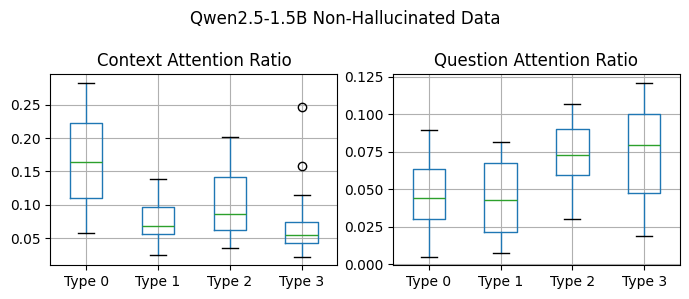

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

cols = []
labels = []

for i in range(4):
    cols.append(f'{name}_context_attention_{i}')
    labels.append(f'Type {i}')
model_data.boxplot(column=cols, ax=axes[0])
axes[0].set_title('Context Attention Ratio')
axes[0].set_xticklabels(labels)

cols = []
labels = []

for i in range(4):
    cols.append(f'{name}_question_attention_{i}')
    labels.append(f'Type {i}')
model_data.boxplot(column=cols, ax=axes[1])
axes[1].set_title('Question Attention Ratio')
axes[1].set_xticklabels(labels)

plt.suptitle('Qwen2.5-1.5B Non-Hallucinated Data')
plt.tight_layout()
plt.show()

# QWEN 2.5

In [31]:
name = "Qwen2.5-1.5B"
hallucinated_df = annotated_results_df[annotated_results_df[f'{name}_hallucinated'] == True]

In [32]:
for name in model_names:
    hallucinated_df[f'{name}_context_weights'] = hallucinated_df[f'{name}_context_weights'].apply(ast.literal_eval)
    hallucinated_df[f'{name}_question_weights'] = hallucinated_df[f'{name}_question_weights'].apply(ast.literal_eval)
    hallucinated_df[f'{name}_context_ave'] = hallucinated_df[f'{name}_context_ave'].apply(ast.literal_eval)
    hallucinated_df[f'{name}_question_ave'] = hallucinated_df[f'{name}_question_ave'].apply(ast.literal_eval)
    hallucinated_df[f'{name}_total_ave'] = hallucinated_df[f'{name}_total_ave'].apply(ast.literal_eval)

In [33]:
for name in model_names:
    hallucinated_df[f'{name}_context_similarity'] = hallucinated_df.apply(lambda row: get_similarity(row[f'{name}_context_ave'], row[f'{name}_context_weights']), axis=1)
    hallucinated_df[f'{name}_question_similarity'] = hallucinated_df.apply(lambda row: get_similarity(row[f'{name}_question_ave'], row[f'{name}_question_weights']), axis=1)

In [34]:
# Get similarity average for hallucinated responses
for name in model_names:
    model = (hallucinated_df[f'{name}_context_similarity'].mean(), hallucinated_df[f'{name}_question_similarity'].mean())
    print(f'{name}: {model}')

LLaMA3.2-1B: (np.float32(0.7336628), np.float32(0.8639713))
LLaMA3.2-3B: (np.float32(0.8013755), np.float32(0.83988035))
Qwen2.5-1.5B: (np.float32(0.64825356), np.float32(0.7533635))
Qwen2.5-3B: (np.float32(0.64863735), np.float32(0.9382559))


In [35]:
for name in model_names:
    model = (filtered_df[f'{name}_context_similarity'].mean(), filtered_df[f'{name}_question_similarity'].mean())
    print(f'{name}: {model}')

LLaMA3.2-1B: (np.float32(0.7511344), np.float32(0.8674709))
LLaMA3.2-3B: (np.float32(0.8039748), np.float32(0.8100082))
Qwen2.5-1.5B: (np.float32(0.6078829), np.float32(0.8250861))
Qwen2.5-3B: (np.float32(0.6911096), np.float32(0.93117076))


In [36]:
# Get all grouped types
hallu_types = [0, 0, 0, 0]
for i in range(4):
    hallu_types[i] = hallucinated_df[hallucinated_df['type'] == i]

In [37]:
name = model_names[2]
hallu_type_data = [pd.DataFrame() for _ in range(4)]

for i in range(4):
    hallu_type_data[i][f'{name}_context_attention'] = hallu_types[i].apply(lambda row: sum(row[f'{name}_context_ave']) / sum(row[f'{name}_total_ave']), axis=1)
    hallu_type_data[i][f'{name}_question_attention'] = hallu_types[i].apply(lambda row: sum(row[f'{name}_question_ave']) / sum(row[f'{name}_total_ave']), axis=1)
    hallu_type_data[i][f'{name}_context_similarity'] = hallu_types[i][f'{name}_context_similarity']
    hallu_type_data[i][f'{name}_question_similarity'] = hallu_types[i][f'{name}_question_similarity']


In [38]:
hallu_type_summary = pd.DataFrame(columns=['type', 'model', 'avg_context_attn', 'avg_question_attn', 'avg_context_similarity', 'avg_question_similarity'])

for i in range(4):
    if hallu_types[i].shape[0] == 0:
        continue

    hallu_type_summary.loc[len(hallu_type_summary)] = [i, name, hallu_type_data[i][f'{name}_context_attention'].mean(), 
                                            hallu_type_data[i][f'{name}_question_attention'].mean(), hallu_types[i][f'{name}_context_similarity'].mean(), 
                                            hallu_types[i][f'{name}_question_similarity'].mean()]

hallu_type_summary.sort_values(by=['model', 'type'], ascending=[True, True]).to_latex()

'\\begin{tabular}{lrlrrrr}\n\\toprule\n & type & model & avg_context_attn & avg_question_attn & avg_context_similarity & avg_question_similarity \\\\\n\\midrule\n0 & 0 & Qwen2.5-1.5B & 0.067063 & 0.038920 & 0.605054 & 0.857533 \\\\\n1 & 1 & Qwen2.5-1.5B & 0.179017 & 0.024961 & 0.700826 & 0.741424 \\\\\n2 & 2 & Qwen2.5-1.5B & 0.015739 & 0.023235 & 0.384826 & 0.658325 \\\\\n3 & 3 & Qwen2.5-1.5B & 0.224511 & 0.027833 & 0.766189 & 0.739906 \\\\\n\\bottomrule\n\\end{tabular}\n'

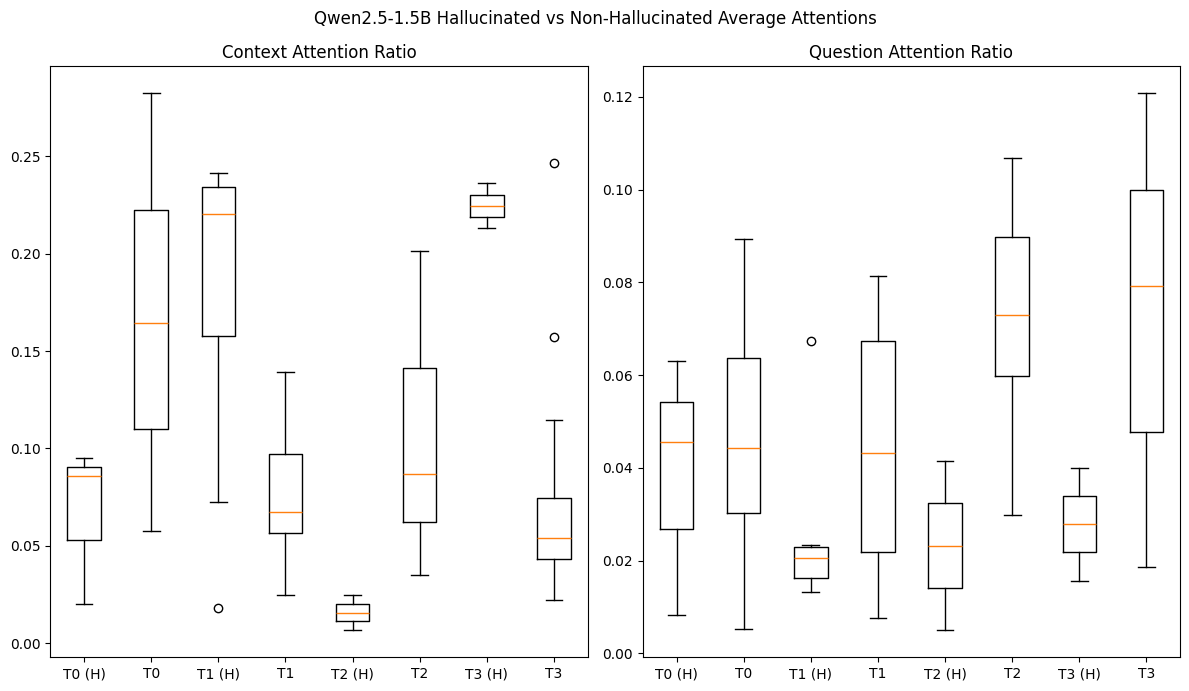

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(12, 7))

cols = []
labels = []
for i in range(4):
    labels.append(f"T{i} (H)")
    labels.append(f"T{i}")

for i in range(4):
    cols.append(hallu_type_data[i][f'{name}_context_attention'].dropna())
    cols.append(model_data[f'{name}_context_attention_{i}'].dropna())
axes[0].boxplot(cols, labels=labels)
axes[0].set_title('Context Attention Ratio')

cols = []
labels = []
for i in range(4):
    labels.append(f"T{i} (H)")
    labels.append(f"T{i}")

for i in range(4):
    cols.append(hallu_type_data[i][f'{name}_question_attention'].dropna())
    cols.append(model_data[f'{name}_question_attention_{i}'].dropna())
axes[1].boxplot(cols, labels=labels)
axes[1].set_title('Question Attention Ratio')

plt.suptitle('Qwen2.5-1.5B Hallucinated vs Non-Hallucinated Average Attentions')
plt.tight_layout()
plt.show()

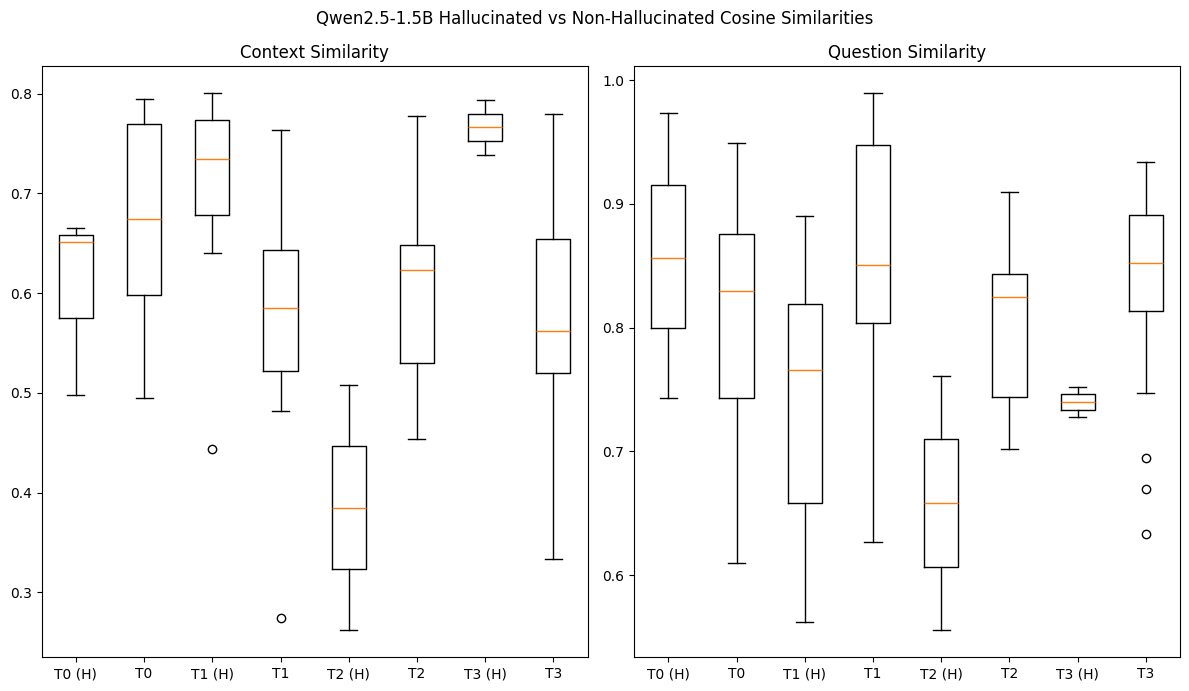

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(12, 7))

cols = []
for i in range(4):
    cols.append(hallu_type_data[i][f'{name}_context_similarity'])
    cols.append(model_data[f'{name}_context_similarity_{i}'].dropna())
axes[0].boxplot(cols, labels=labels)
axes[0].set_title('Context Similarity')

cols = []
for i in range(4):
    cols.append(hallu_type_data[i][f'{name}_question_similarity'])
    cols.append(model_data[f'{name}_question_similarity_{i}'].dropna())
axes[1].boxplot(cols, labels=labels)
axes[1].set_title('Question Similarity')

plt.suptitle('Qwen2.5-1.5B Hallucinated vs Non-Hallucinated Cosine Similarities')
plt.tight_layout()
plt.show()

In [41]:
import numpy as np
from scipy import stats

# Example data (two groups)
for i in range(4):
    group1 = np.array(hallu_type_data[i][f'{name}_context_attention'])
    group2 = np.array(model_data[f'{name}_context_attention_{i}'].dropna())

    # Independent t-test
    t_stat, p_val = stats.ttest_ind(group1, group2)

    print("t-statistic:", t_stat)
    print("p-value:", p_val)

    if p_val < 0.05:
        print("✅ Significant difference between means")
    else:
        print("❌ No significant difference between means")

    print()


t-statistic: -2.173783554426829
p-value: 0.04330845696634082
✅ Significant difference between means

t-statistic: 3.7176712058195895
p-value: 0.0015754154117349304
✅ Significant difference between means

t-statistic: -2.3161880558074417
p-value: 0.03254297669616063
✅ Significant difference between means

t-statistic: 3.8805955513358272
p-value: 0.0010957913259104807
✅ Significant difference between means



In [42]:
# Example data (two groups)
for i in range(4):
    group1 = np.array(hallu_type_data[i][f'{name}_question_attention'])
    group2 = np.array(model_data[f'{name}_question_attention_{i}'].dropna())

    # Independent t-test
    t_stat, p_val = stats.ttest_ind(group1, group2)

    print("t-statistic:", t_stat)
    print("p-value:", p_val)

    if p_val < 0.05:
        print("✅ Significant difference between means")
    else:
        print("❌ No significant difference between means")

    print()

t-statistic: -0.414197972297022
p-value: 0.6836230630775049
❌ No significant difference between means

t-statistic: -1.8598647139800613
p-value: 0.07932715898355566
❌ No significant difference between means

t-statistic: -2.846125144961234
p-value: 0.01072073940982782
✅ Significant difference between means

t-statistic: -1.8339482476175486
p-value: 0.0832494325626951
❌ No significant difference between means



In [43]:
# Example data (two groups)
print(f"Model: {name}")
for i in range(4):
    group1 = np.array(hallu_type_data[i][f'{name}_context_similarity'])
    group2 = np.array(model_data[f'{name}_context_similarity_{i}'].dropna())

    # Independent t-test
    t_stat, p_val = stats.ttest_ind(group1, group2)

    print(f"Type {i}")
    print("t-statistic:", t_stat)
    print("p-value:", p_val)

    if p_val < 0.05:
        print("✅ Significant difference between means")
    else:
        print("❌ No significant difference between means")

    print()

Model: Qwen2.5-1.5B
Type 0
t-statistic: -1.0879316720173127
p-value: 0.2909785321582273
❌ No significant difference between means

Type 1
t-statistic: 2.1778271643969602
p-value: 0.04296225769978958
✅ Significant difference between means

Type 2
t-statistic: -3.020228458397596
p-value: 0.0073544638770044034
✅ Significant difference between means

Type 3
t-statistic: 2.3020927274523486
p-value: 0.03348599438077308
✅ Significant difference between means



In [44]:
print(f"Model: {name}")
for i in range(4):
    group1 = np.array(hallu_type_data[i][f'{name}_question_similarity'])
    group2 = np.array(model_data[f'{name}_question_similarity_{i}'].dropna())

    # Independent t-test
    t_stat, p_val = stats.ttest_ind(group1, group2)

    print(f"Type {i}")
    print("t-statistic:", t_stat)
    print("p-value:", p_val)

    if p_val < 0.05:
        print("✅ Significant difference between means")
    else:
        print("❌ No significant difference between means")

    print()

Model: Qwen2.5-1.5B
Type 0
t-statistic: 0.6082769288097138
p-value: 0.5506029842573055
❌ No significant difference between means

Type 1
t-statistic: -2.2518763112367535
p-value: 0.037055247219681196
✅ Significant difference between means

Type 2
t-statistic: -2.668197916550489
p-value: 0.015673782887078585
✅ Significant difference between means

Type 3
t-statistic: -1.391010439365506
p-value: 0.18117931379995864
❌ No significant difference between means



# LLaMA 1B

In [45]:
# Get all grouped types
hallu_types = [0, 0, 0, 0]
for i in range(4):
    hallu_types[i] = hallucinated_df[hallucinated_df['type'] == i]

In [46]:
name = model_names[0]
hallu_type_data = [pd.DataFrame() for _ in range(4)]
for i in range(4):
    hallu_type_data[i][f'{name}_context_attention'] = hallu_types[i].apply(lambda row: sum(row[f'{name}_context_ave']) / sum(row[f'{name}_total_ave']), axis=1)
    hallu_type_data[i][f'{name}_question_attention'] = hallu_types[i].apply(lambda row: sum(row[f'{name}_question_ave']) / sum(row[f'{name}_total_ave']), axis=1)
    hallu_type_data[i][f'{name}_context_similarity'] = hallu_types[i][f'{name}_context_similarity']
    hallu_type_data[i][f'{name}_question_similarity'] = hallu_types[i][f'{name}_question_similarity']


In [47]:
hallu_type_summary = pd.DataFrame(columns=['type', 'model', 'avg_context_attn', 'avg_question_attn', 'avg_context_similarity', 'avg_question_similarity'])

for i in range(4):
    if hallu_types[i].shape[0] == 0:
        continue

    hallu_type_summary.loc[len(hallu_type_summary)] = [i, name, hallu_type_data[i][f'{name}_context_attention'].mean(), 
                                            hallu_type_data[i][f'{name}_question_attention'].mean(), hallu_types[i][f'{name}_context_similarity'].mean(), 
                                            hallu_types[i][f'{name}_question_similarity'].mean()]

hallu_type_summary.sort_values(by=['model', 'type'], ascending=[True, True]).to_latex()

'\\begin{tabular}{lrlrrrr}\n\\toprule\n & type & model & avg_context_attn & avg_question_attn & avg_context_similarity & avg_question_similarity \\\\\n\\midrule\n0 & 0 & LLaMA3.2-1B & 0.058686 & 0.026143 & 0.737572 & 0.843863 \\\\\n1 & 1 & LLaMA3.2-1B & 0.029542 & 0.032919 & 0.710383 & 0.866305 \\\\\n2 & 2 & LLaMA3.2-1B & 0.017870 & 0.017571 & 0.752411 & 0.881409 \\\\\n3 & 3 & LLaMA3.2-1B & 0.014610 & 0.025522 & 0.802170 & 0.867359 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [48]:
# Get all grouped types
types = [0, 0, 0, 0]
for i in range(4):
    types[i] = filtered_df[filtered_df['type'] == i]

In [49]:
type_data = [pd.DataFrame() for _ in range(4)]

for i in range(4):
    type_data[i][f'{name}_context_attention_{i}'] = types[i].apply(lambda row: sum(row[f'{name}_context_ave']) / sum(row[f'{name}_total_ave']), axis=1)
    type_data[i][f'{name}_question_attention_{i}'] = types[i].apply(lambda row: sum(row[f'{name}_question_ave']) / sum(row[f'{name}_total_ave']), axis=1)
    type_data[i][f'{name}_context_similarity_{i}'] = types[i][f'{name}_context_similarity']
    type_data[i][f'{name}_question_similarity_{i}'] = types[i][f'{name}_question_similarity']


In [50]:
type_summary = pd.DataFrame(columns=['type', 'model', 'avg_context_attn', 'avg_question_attn', 'avg_context_similarity', 'avg_question_similarity'])

for i in range(4):
    type_summary.loc[len(type_summary)] = [i, name, type_data[i][f'{name}_context_attention_{i}'].mean(), 
                                            type_data[i][f'{name}_question_attention_{i}'].mean(), type_data[i][f'{name}_context_similarity_{i}'].mean(), 
                                            type_data[i][f'{name}_question_similarity_{i}'].mean()]

type_summary.sort_values(by=['model', 'type'], ascending=[True, True]).to_latex()

'\\begin{tabular}{lrlrrrr}\n\\toprule\n & type & model & avg_context_attn & avg_question_attn & avg_context_similarity & avg_question_similarity \\\\\n\\midrule\n0 & 0 & LLaMA3.2-1B & 0.048148 & 0.023741 & 0.756163 & 0.912534 \\\\\n1 & 1 & LLaMA3.2-1B & 0.026099 & 0.028660 & 0.785394 & 0.869807 \\\\\n2 & 2 & LLaMA3.2-1B & 0.026639 & 0.027287 & 0.743915 & 0.838431 \\\\\n3 & 3 & LLaMA3.2-1B & 0.021296 & 0.031963 & 0.730765 & 0.852394 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [51]:
model_data = pd.concat([type_data[t][[f'{name}_context_attention_{t}', f'{name}_question_attention_{t}', f'{name}_context_similarity_{t}', f'{name}_question_similarity_{t}']].reset_index(drop=True) for t in range(len(type_data))], axis=1)

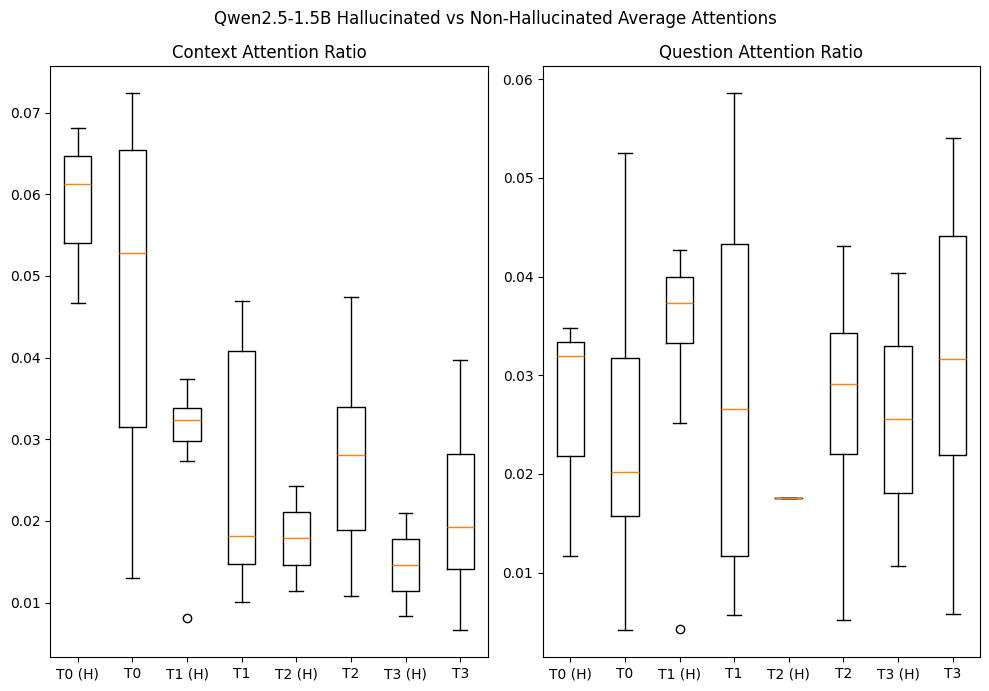

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(10, 7))

cols = []
labels = []
for i in range(4):
    labels.append(f"T{i} (H)")
    labels.append(f"T{i}")

for i in range(4):
    cols.append(hallu_type_data[i][f'{name}_context_attention'].dropna())
    cols.append(model_data[f'{name}_context_attention_{i}'].dropna())
axes[0].boxplot(cols, labels=labels)
axes[0].set_title('Context Attention Ratio')

cols = []
labels = []
for i in range(4):
    labels.append(f"T{i} (H)")
    labels.append(f"T{i}")
    
for i in range(4):
    cols.append(hallu_type_data[i][f'{name}_question_attention'].dropna())
    cols.append(model_data[f'{name}_question_attention_{i}'].dropna())
axes[1].boxplot(cols, labels=labels)
axes[1].set_title('Question Attention Ratio')

plt.suptitle('Qwen2.5-1.5B Hallucinated vs Non-Hallucinated Average Attentions')
plt.tight_layout()
plt.show()

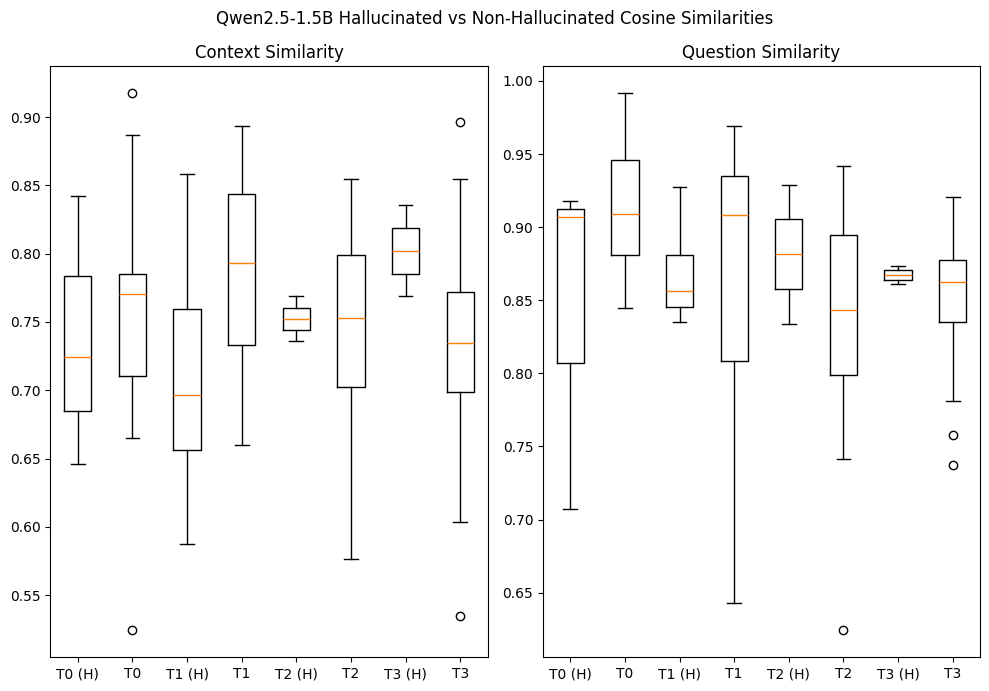

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(10, 7))

cols = []
labels = []
for i in range(4):
    labels.append(f"T{i} (H)")
    labels.append(f"T{i}")

for i in range(4):
    cols.append(hallu_type_data[i][f'{name}_context_similarity'].dropna())
    cols.append(model_data[f'{name}_context_similarity_{i}'].dropna())
axes[0].boxplot(cols, labels=labels)
axes[0].set_title('Context Similarity')

cols = []
labels = []
for i in range(4):
    labels.append(f"T{i} (H)")
    labels.append(f"T{i}")
    
for i in range(4):
    cols.append(hallu_type_data[i][f'{name}_question_similarity'].dropna())
    cols.append(model_data[f'{name}_question_similarity_{i}'].dropna())
axes[1].boxplot(cols, labels=labels)
axes[1].set_title('Question Similarity')

plt.suptitle('Qwen2.5-1.5B Hallucinated vs Non-Hallucinated Cosine Similarities')
plt.tight_layout()
plt.show()

In [54]:
import numpy as np
from scipy import stats

# Example data (two groups)
for i in range(4):
    group1 = np.array(hallu_type_data[i][f'{name}_context_attention'])
    group2 = np.array(model_data[f'{name}_context_attention_{i}'].dropna())

    # Independent t-test
    t_stat, p_val = stats.ttest_ind(group1, group2)

    print("t-statistic:", t_stat)
    print("p-value:", p_val)

    if p_val < 0.05:
        print("✅ Significant difference between means")
    else:
        print("❌ No significant difference between means")

    print()


t-statistic: 0.9081037521530937
p-value: 0.37582164881610625
❌ No significant difference between means

t-statistic: 0.5954748885621881
p-value: 0.5589394203851172
❌ No significant difference between means

t-statistic: -1.1618032840781212
p-value: 0.2604898295069688
❌ No significant difference between means

t-statistic: -0.9071804516339669
p-value: 0.3762965690840112
❌ No significant difference between means



In [55]:
# Example data (two groups)
for i in range(4):
    group1 = np.array(hallu_type_data[i][f'{name}_question_attention'])
    group2 = np.array(model_data[f'{name}_question_attention_{i}'].dropna())

    # Independent t-test
    t_stat, p_val = stats.ttest_ind(group1, group2)

    print("t-statistic:", t_stat)
    print("p-value:", p_val)

    if p_val < 0.05:
        print("✅ Significant difference between means")
    else:
        print("❌ No significant difference between means")

    print()

t-statistic: 0.31452851693067874
p-value: 0.756736211824323
❌ No significant difference between means

t-statistic: 0.5539466398502241
p-value: 0.5864319276013713
❌ No significant difference between means

t-statistic: -1.2067796408641398
p-value: 0.24313801054232684
❌ No significant difference between means

t-statistic: -0.609686877585389
p-value: 0.5496889267933615
❌ No significant difference between means



In [56]:
# Example data (two groups)
print(f"Model: {name}")
for i in range(4):
    group1 = np.array(hallu_type_data[i][f'{name}_context_similarity'])
    group2 = np.array(model_data[f'{name}_context_similarity_{i}'].dropna())

    # Independent t-test
    t_stat, p_val = stats.ttest_ind(group1, group2)

    print(f"Type {i}")
    print("t-statistic:", t_stat)
    print("p-value:", p_val)

    if p_val < 0.05:
        print("✅ Significant difference between means")
    else:
        print("❌ No significant difference between means")

    print()

Model: LLaMA3.2-1B
Type 0
t-statistic: -0.32787260205365776
p-value: 0.7467909327696376
❌ No significant difference between means

Type 1
t-statistic: -1.9671219706108525
p-value: 0.06477728594869049
❌ No significant difference between means

Type 2
t-statistic: 0.1431538586829707
p-value: 0.8877590353973311
❌ No significant difference between means

Type 3
t-statistic: 1.1409201381424392
p-value: 0.26885604103343186
❌ No significant difference between means



In [57]:
print(f"Model: {name}")
for i in range(4):
    group1 = np.array(hallu_type_data[i][f'{name}_question_similarity'])
    group2 = np.array(model_data[f'{name}_question_similarity_{i}'].dropna())

    # Independent t-test
    t_stat, p_val = stats.ttest_ind(group1, group2)

    print(f"Type {i}")
    print("t-statistic:", t_stat)
    print("p-value:", p_val)

    if p_val < 0.05:
        print("✅ Significant difference between means")
    else:
        print("❌ No significant difference between means")

    print()

Model: LLaMA3.2-1B
Type 0
t-statistic: -1.9255479917212028
p-value: 0.07010802421384442
❌ No significant difference between means

Type 1
t-statistic: -0.09968167613496537
p-value: 0.9216988585547233
❌ No significant difference between means

Type 2
t-statistic: 0.7660021347262709
p-value: 0.453603710997461
❌ No significant difference between means

Type 3
t-statistic: 0.4047551681596164
p-value: 0.6904269447656051
❌ No significant difference between means



### SECTION LAST

In [58]:
import pandas as pd
import ast
from scipy.special import softmax
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

model_names = ["LLaMA3.2-1B", "LLaMA3.2-3B", "Qwen2.5-1.5B", "Qwen2.5-3B"]

results_df = pd.read_csv('../Data Files/annotated_complete_results.csv')

In [59]:
for name in model_names:
    results_df[f'{name}_context_weights'] = results_df[f'{name}_context_weights'].apply(ast.literal_eval)
    results_df[f'{name}_question_weights'] = results_df[f'{name}_question_weights'].apply(ast.literal_eval)
    results_df[f'{name}_context_ave'] = results_df[f'{name}_context_ave'].apply(ast.literal_eval)
    results_df[f'{name}_question_ave'] = results_df[f'{name}_question_ave'].apply(ast.literal_eval)
    results_df[f'{name}_total_ave'] = results_df[f'{name}_total_ave'].apply(ast.literal_eval)

In [60]:
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.special import softmax

def softmax_transform(data):
    return np.array(softmax(data), dtype='float32').reshape(1, -1)

def get_similarity(llm_attn, human_attn):
    normalized_llm = np.array(llm_attn, dtype='float32').reshape(1, -1)
    normalized_human = softmax_transform(human_attn)
    return cosine_similarity(normalized_llm, normalized_human)[0][0]

In [61]:
for name in model_names:
    results_df[f'{name}_context_similarity'] = results_df.apply(lambda row: get_similarity(row[f'{name}_context_ave'], row[f'{name}_context_weights']), axis=1)
    results_df[f'{name}_question_similarity'] = results_df.apply(lambda row: get_similarity(row[f'{name}_question_ave'], row[f'{name}_question_weights']), axis=1)
    results_df[f'{name}_context_length'] = results_df['context'].apply(lambda x: len(x))
    results_df[f'{name}_question_length'] = results_df['question'].apply(lambda x: len(x))
    results_df[f'{name}_context_attention'] = results_df.apply(lambda row: sum(row[f'{name}_context_ave']) / sum(row[f'{name}_total_ave']), axis=1)
    results_df[f'{name}_question_attention'] = results_df.apply(lambda row: sum(row[f'{name}_question_ave']) / sum(row[f'{name}_total_ave']), axis=1)

In [62]:
context_corrs = [0, 0, 0, 0]
question_corrs = [0, 0, 0, 0]

for i in range(len(model_names)):
    name = model_names[i]
    context_corrs[i] = results_df[f'{name}_context_similarity'].corr(results_df[f'{name}_context_length'])
    question_corrs[i] = results_df[f'{name}_question_similarity'].corr(results_df[f'{name}_question_length'])

In [63]:
answer_dfs = []
instruction_dfs = []
non_hallu_dfs = results_df

for name in model_names:
    answer_dfs.append(results_df[results_df[f'{name}_hallucination_type'] == "answer"])
    instruction_dfs.append(results_df[results_df[f'{name}_hallucination_type'] == "instruction"])
    non_hallu_dfs = non_hallu_dfs[results_df[f'{name}_hallucinated'] == False]

    print(results_df[results_df[f'{name}_hallucination_type'] == "answer"].index)
    print(results_df[results_df[f'{name}_hallucination_type'] == "instruction"].index)
    print(non_hallu_dfs[results_df[f'{name}_hallucinated'] == False].index)

Index([0, 4, 11, 12, 19, 20, 21, 24, 30, 31, 36, 39, 45, 55, 56, 65, 74, 75], dtype='int64')
Index([63], dtype='int64')
Index([ 1,  2,  3,  5,  6,  7,  8,  9, 10, 13, 14, 15, 16, 17, 18, 22, 23, 25,
       26, 27, 28, 29, 32, 33, 34, 35, 37, 38, 40, 41, 42, 43, 44, 46, 47, 48,
       49, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 62, 64, 66, 67, 68, 69, 70,
       71, 72, 73, 76, 77, 78, 79],
      dtype='int64')
Index([31, 44, 63], dtype='int64')
Index([], dtype='int64')
Index([ 1,  2,  3,  5,  6,  7,  8,  9, 10, 13, 14, 15, 16, 17, 18, 22, 23, 25,
       26, 27, 28, 29, 32, 33, 34, 35, 37, 38, 40, 41, 42, 43, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 62, 64, 66, 67, 68, 69, 70, 71,
       72, 73, 76, 77, 78, 79],
      dtype='int64')
Index([26, 40, 54, 61, 64], dtype='int64')
Index([3, 13, 36, 44, 47, 49, 51, 55, 57, 72], dtype='int64')
Index([ 1,  2,  5,  6,  7,  8,  9, 10, 14, 15, 16, 17, 18, 22, 23, 25, 27, 28,
       29, 32, 33, 34, 35, 37, 38, 41, 42, 43, 46, 4

In [64]:
hallu_count = []

for i in range(4):
    hallu_count.append([[0, 0, 0, 0], [0, 0, 0, 0]])

for i in range(4):
    for y in range(len(answer_dfs)):
        name = model_names[y]
        ans_df = answer_dfs[y]
        temp_df = ans_df[ans_df['type'] == i]
        ins_df = instruction_dfs[y]
        temp2_df = ins_df[ins_df['type'] == i]

        if not temp_df.empty:
            hallu_count[y][0][i] += temp_df.shape[0]

        if not temp2_df.empty:
            hallu_count[y][1][i] += temp2_df.shape[0]

In [65]:
for y in range(len(answer_dfs)):
    for i in range(4):
        name = model_names[y]
        print(f"{name} (Type: {i}): {hallu_count[y][0][i]} | {hallu_count[y][1][i]}")

LLaMA3.2-1B (Type: 0): 3 | 1
LLaMA3.2-1B (Type: 1): 3 | 0
LLaMA3.2-1B (Type: 2): 7 | 0
LLaMA3.2-1B (Type: 3): 5 | 0
LLaMA3.2-3B (Type: 0): 1 | 0
LLaMA3.2-3B (Type: 1): 1 | 0
LLaMA3.2-3B (Type: 2): 1 | 0
LLaMA3.2-3B (Type: 3): 0 | 0
Qwen2.5-1.5B (Type: 0): 2 | 1
Qwen2.5-1.5B (Type: 1): 2 | 6
Qwen2.5-1.5B (Type: 2): 1 | 1
Qwen2.5-1.5B (Type: 3): 0 | 2
Qwen2.5-3B (Type: 0): 4 | 0
Qwen2.5-3B (Type: 1): 0 | 0
Qwen2.5-3B (Type: 2): 0 | 0
Qwen2.5-3B (Type: 3): 0 | 0


In [66]:
stats_df = pd.DataFrame({
    "Model": [],
    "type": [],
    "Answer": [],
    "Instruction": [],
    "Total": []
})

for y in range(len(answer_dfs)):
    for i in range(4):
        name = model_names[y]

        stats_df = pd.concat(
            [stats_df, pd.DataFrame({
                "Model": [name],
                "type": [i],
                "Answer": [hallu_count[y][0][i]],
                "Instruction": [hallu_count[y][1][i]],
                "Total": [hallu_count[y][0][i] + hallu_count[y][1][i]]
            })],
            ignore_index=True
        )

stats_df = stats_df.astype(
    {
        "Model": "string",
        "type": "int32",
        "Answer": "int32",
        "Instruction": "int32",
        "Total": "int32"
    }
)

stats_df

,Model,type,Answer,Instruction,Total
0,LLaMA3.2-1B,0,3,1,4
1,LLaMA3.2-1B,1,3,0,3
2,LLaMA3.2-1B,2,7,0,7
3,LLaMA3.2-1B,3,5,0,5
4,LLaMA3.2-3B,0,1,0,1
5,LLaMA3.2-3B,1,1,0,1
6,LLaMA3.2-3B,2,1,0,1
7,LLaMA3.2-3B,3,0,0,0
8,Qwen2.5-1.5B,0,2,1,3
9,Qwen2.5-1.5B,1,2,6,8


In [67]:
grouped_by_model = (stats_df.groupby(["Model"]))[["Answer", "Instruction", "Total"]].sum().reset_index()
grouped_by_model["Answer"] = grouped_by_model["Answer"].apply(lambda x: x / 80.0)
grouped_by_model["Total"] = grouped_by_model["Total"].apply(lambda x: x / 80.0)
grouped_by_model["Instruction"] = grouped_by_model["Instruction"].apply(lambda x: x / 80.0)
grouped_by_model

,Model,Answer,Instruction,Total
0,LLaMA3.2-1B,0.2250,0.0125,0.2375
1,LLaMA3.2-3B,0.0375,0.0000,0.0375
2,Qwen2.5-1.5B,0.0625,0.1250,0.1875
3,Qwen2.5-3B,0.0500,0.0000,0.0500


In [68]:
def rename(df, name):
    rename_dict = dict()
    rename_dict[f"{name}_context_attention"] = "context_attention"
    rename_dict[f"{name}_question_attention"] = "question_attention"
    rename_dict[f"{name}_context_similarity"] = "context_similarity"
    rename_dict[f"{name}_question_similarity"] = "question_similarity"
    return df.rename(columns=rename_dict)

In [69]:
# Get all grouped types
answer_hallu_types = []
instruction_hallu_types = []
non_hallu_types = []

for i in range(4):
    answer_hallu_types.append(pd.DataFrame({"context_attention": [], 
                                            "question_attention": [],
                                            "context_similarity": [],
                                            "question_similarity": []}))
    instruction_hallu_types.append(pd.DataFrame({"context_attention": [], 
                                            "question_attention": [],
                                            "context_similarity": [],
                                            "question_similarity": []}))
    non_hallu_types.append(pd.DataFrame({"context_attention": [], 
                                            "question_attention": [],
                                            "context_similarity": [],
                                            "question_similarity": []}))

for i in range(4):
    for y in range(len(answer_dfs)):
        name = model_names[y]
        var = pd.DataFrame({"context_attention": [], 
                    "question_attention": [],
                    "context_similarity": [],
                    "question_similarity": []})

        ans_df = answer_dfs[y]
        temp_df = ans_df[ans_df['type'] == i]

        if not temp_df.empty:
            answer_hallu_types[i] = pd.concat(
                [answer_hallu_types[i], rename(df=temp_df, name=name)],
                ignore_index=True
            )

    for y in range(len(instruction_dfs)):
        name = model_names[y]
        var = pd.DataFrame({"context_attention": [], 
                    "question_attention": [],
                    "context_similarity": [],
                    "question_similarity": []})

        ins_df = instruction_dfs[y]
        temp_df = ins_df[ins_df['type'] == i]

        if not temp_df.empty:
            instruction_hallu_types[i] = pd.concat(
                [instruction_hallu_types[i], rename(df=temp_df, name=name)],
                ignore_index=True
            )

    for name in model_names:
        var = pd.DataFrame({"context_attention": [], 
                    "question_attention": [],
                    "context_similarity": [],
                    "question_similarity": []})

        non_df = non_hallu_dfs
        temp_df = non_df[non_df['type'] == i]

        if not temp_df.empty:
            non_hallu_types[i] = pd.concat(
                [non_hallu_types[i], rename(df=temp_df, name=name)],
                ignore_index=True
            )

In [70]:
for i in range(4):
    group1 = np.array(answer_hallu_types[i]['context_attention'].dropna())
    group2 = np.array(non_hallu_types[i]['context_attention'].dropna())

    # Independent t-test
    t_stat, p_val = stats.ttest_ind(group1, group2)

    print("t-statistic:", t_stat)
    print("p-value:", p_val)

    if p_val < 0.05:
        print("✅ Significant difference between means")
    else:
        print("❌ No significant difference between means")

    print()

t-statistic: -1.0664715924687056
p-value: 0.2907868746588985
❌ No significant difference between means

t-statistic: 0.9429670467877312
p-value: 0.3508468387398306
❌ No significant difference between means

t-statistic: -1.594003688887538
p-value: 0.11666639915725818
❌ No significant difference between means

t-statistic: -1.3942195948312122
p-value: 0.16885831106181406
❌ No significant difference between means



In [71]:
for i in range(4):
    group1 = np.array(answer_hallu_types[i]['question_attention'].dropna())
    group2 = np.array(non_hallu_types[i]['question_attention'].dropna())

    # Independent t-test
    t_stat, p_val = stats.ttest_ind(group1, group2)

    print("t-statistic:", t_stat)
    print("p-value:", p_val)

    if p_val < 0.05:
        print("✅ Significant difference between means")
    else:
        print("❌ No significant difference between means")

    print()

t-statistic: 1.1792926792176524
p-value: 0.24326771575865191
❌ No significant difference between means

t-statistic: 0.5784484163107873
p-value: 0.5659106526799531
❌ No significant difference between means

t-statistic: -2.382401486743283
p-value: 0.020684268910020658
✅ Significant difference between means

t-statistic: -1.364299923652807
p-value: 0.17802992832962697
❌ No significant difference between means



In [72]:
for i in range(4):
    group1 = np.array(answer_hallu_types[i]['context_similarity'].dropna())
    group2 = np.array(non_hallu_types[i]['context_similarity'].dropna())

    # Independent t-test
    t_stat, p_val = stats.ttest_ind(group1, group2)

    print("t-statistic:", t_stat)
    print("p-value:", p_val)

    if p_val < 0.05:
        print("✅ Significant difference between means")
    else:
        print("❌ No significant difference between means")

    print()

t-statistic: -1.3456619127675697
p-value: 0.18383480279406217
❌ No significant difference between means

t-statistic: -0.42673752365497863
p-value: 0.6716513304477875
❌ No significant difference between means

t-statistic: -0.05305751961916553
p-value: 0.957878326059632
❌ No significant difference between means

t-statistic: 0.8888998607083081
p-value: 0.3779282213292078
❌ No significant difference between means



In [73]:
for i in range(4):
    group1 = np.array(answer_hallu_types[i]['question_similarity'].dropna())
    group2 = np.array(non_hallu_types[i]['question_similarity'].dropna())

    # Independent t-test
    t_stat, p_val = stats.ttest_ind(group1, group2)

    print("t-statistic:", t_stat)
    print("p-value:", p_val)

    if p_val < 0.05:
        print("✅ Significant difference between means")
    else:
        print("❌ No significant difference between means")

    print()

t-statistic: 0.11245093844014203
p-value: 0.9108679981910668
❌ No significant difference between means

t-statistic: -1.0418994593525333
p-value: 0.3031494768301667
❌ No significant difference between means

t-statistic: -0.9365936149902855
p-value: 0.35306215106300487
❌ No significant difference between means

t-statistic: -0.9888345507008285
p-value: 0.3270744865400729
❌ No significant difference between means

